# Experiment: Million Songs Dataset

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,RidgeCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
import seaborn as sns

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

df=pd.read_csv('YearPredictionMSD.txt',header=None,sep = ',')
#smaller dataset
train=df.iloc[300000:300700] 
test=df.iloc[500000:500300] 

train_y = train[0]
test_y = test[0] #response:year
train_x = train
test_x = test
del train_x[0]
del test_x[0]
total_x=pd.concat([train_x,test_x])
x=preprocessing.StandardScaler().fit(total_x).transform(total_x) #normalize
x=pd.DataFrame(x)
train_x=x.iloc[:700]
test_x=x.iloc[700:]

train_x.reset_index(drop=True, inplace=True) 
test_x.reset_index(drop=True, inplace=True) 
train_y.reset_index(drop=True, inplace=True) 
test_y.reset_index(drop=True, inplace=True) 

train_x ##display the data

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,-1.169588,-0.913331,-1.303357,0.366642,-1.446675,-0.408470,0.866105,0.914454,-1.242843,-0.667838,...,0.207254,0.352000,-1.993373,-0.121706,-0.624721,-3.186580,2.233731,-1.497663,1.015620,1.535324
1,-0.384652,0.083956,-0.409324,0.340569,-0.922879,0.015633,1.158662,0.921513,0.571624,0.059751,...,2.548116,1.116907,-0.863423,-1.574714,1.571018,0.933343,-0.660936,0.018256,-0.441595,0.061384
2,-0.474117,1.071657,-2.011545,1.578102,-0.387551,0.668625,1.009691,-1.046157,0.164916,0.055518,...,-0.107606,-4.416389,6.454818,3.133579,4.412800,-6.273857,-2.294102,6.551096,-0.142954,-0.990494
3,-1.085627,1.033851,-1.001179,2.001694,0.231899,1.523338,1.051318,1.507985,-0.941449,-0.231110,...,0.101883,3.043570,1.424674,-1.320191,1.222839,0.278665,2.211740,0.589111,-2.269302,1.055646
4,-0.705294,-0.778753,-2.057925,-0.842471,0.976928,-0.353554,-0.405709,0.509083,0.569620,-0.519164,...,-1.579429,0.847409,-1.423293,0.122463,-0.858162,-1.384214,0.440914,-1.079154,-0.234252,0.420268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,-1.448799,0.325952,0.582353,0.258919,0.149646,-0.474193,-1.217127,-0.916761,0.088114,-0.320500,...,0.175976,-0.362254,-1.443022,-0.329998,-0.809020,-0.096618,-1.097373,1.158430,-0.030136,-0.139725
696,-0.743319,0.679493,-0.121131,0.266191,0.153593,0.116883,0.285190,0.262373,0.744065,1.012218,...,0.336759,-0.120216,-0.228381,-0.525685,0.470486,-0.179525,-0.485096,-0.265838,-0.166360,-0.097013
697,-1.079830,0.074670,-0.605215,-0.890968,0.940719,-0.745934,-2.093624,-0.008216,1.374812,1.199631,...,0.253918,0.084684,-0.654068,-0.514407,-0.104413,0.146940,-0.811716,0.178947,0.876225,0.210794
698,-0.628019,0.188730,0.035737,-0.332677,0.625774,-0.682705,0.116143,-0.111752,1.780001,0.683753,...,1.043273,0.018961,-0.808076,0.129063,-0.854428,0.051633,0.294883,0.436294,-0.226600,2.013739


In [38]:
nntrain_x = torch.from_numpy(train_x.to_numpy()).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float()) 
nntest_x= torch.from_numpy(test_x.to_numpy()).float()
nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len

## 1. DNN

In [3]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(90, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-6,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
dnn_trainloss=[]
dnn_testloss=[]
t0=time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    
    if epoch>100 and float(test_loss)>max(dnn_testloss[-100:-1]):
        break
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    
    dnn_trainloss.append(float(train_loss))
    dnn_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("DNN complexity and model fitted in %.3f s" % dnn_fit)

Net(
  (fc1): Linear(in_features=90, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 3984438.0
            Test  set - loss: 4001260.5
            
epoch 100
            Train set - loss: 399.58258056640625
            Test  set - loss: 2541.88427734375
            
epoch 200
            Train set - loss: 151.03475952148438
            Test  set - loss: 915.9685668945312
            
epoch 300
            Train set - loss: 84.96205139160156
            Test  set - loss: 690.5421752929688
            
epoch 400
            Train set - loss: 58.495849609375
            Test  set - loss: 630.4786987304688
            
epoch 500
            Train set - loss: 59.73417663574219
            Test  set - loss: 593.3506469726562
            
epoch 600
            Train set - loss: 48.43214416503906
            Test  set - loss: 594.4166870117188
            
ep

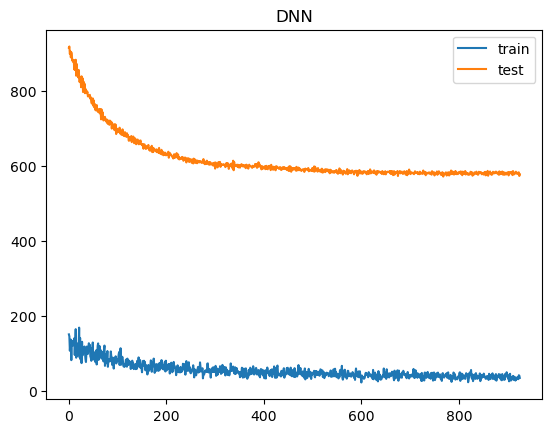

In [4]:
plt.plot(dnn_trainloss[200:])
plt.plot(dnn_testloss[200:])
plt.legend(['train','test'])
plt.title('DNN')
plt.show()

In [ ]:
#predict
x0=torch.from_numpy(test_x[:300].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:300].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[2009.8662 1995.0034 1995.8103 1993.2722 1967.9526 1995.616  1993.1023
 1984.5717 1956.053  2052.538  1998.8594 1996.1492 2007.8044 2094.8936
 1996.214  1998.3212 2023.0339 2007.9916 1996.6873 2006.2012 1992.9655
 2008.447  2003.084  2006.6176 2005.1211 1998.6244 1981.2644 1990.3889
 1988.553  1996.0564 1996.4429 1996.379  2000.3834 2000.4506 1990.8502
 1991.5233 2005.4056 1986.5293 1993.7524 1994.9631 2021.8197 1974.8461
 1985.6997 1996.3734 1986.5724 2138.2334 1967.6622 2008.169  2167.4866
 1949.4005 1975.5488 1930.982  2004.7349 2008.4417 2028.6278 2036.2114
 2010.0999 2016.37   2001.7365 2001.4053 2002.6829 1998.3738 2006.5432
 2004.5957 1998.7206 2001.4896 2004.5957 2002.9324 2006.0273 1963.497
 2013.3618 1960.0719 1977.1788 1973.7478 1971.0902 1973.0684 2063.8765
 2059.8442 2046.7124 2157.7136 2078.3716 1982.5956 2017.4602 1976.3568
 1978.8015 1991.0945 2047.4651 2023.1187 1992.7375 1979.336  2054.2236
 2002.4612 1983.9093 1998.103  1990.9263 1996.8903 2010.292  1995.9662
 1996.7

In [ ]:
#bootstrap  
boottime=80
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = Net()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-6,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
    dnn_testloss=[]
    t0=time.time()
    for epoch in range(2000): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()

        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred,y)
        
        if epoch>100 and float(test_loss)>max(dnn_testloss[-100:-1]):
            break
        dnn_testloss.append(float(test_loss))
    
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

100%|██████████| 80/80 [27:22<00:00, 20.54s/it]


In [ ]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,77]-bootbase)
upper=bootbase-(sorted_bootlist[:,2]-bootbase)
print("confidence interval length",sorted_bootlist[:,77]-sorted_bootlist[:,2])
dnn_length=(sorted_bootlist[:,77]-sorted_bootlist[:,2]).mean()
print("average confidence interval length",dnn_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
dnn_coverage=cover/300
print("95 coverage",dnn_coverage)

confidence interval length [ 67.00256   60.99182   45.463013 105.73218  187.40955   40.641357
  49.288086  60.26367  222.00671  132.18457   47.295288  99.760376
  98.47058  355.99426   76.5459    39.533203 127.91785   37.11438
  28.20105   42.63977  216.18689   65.93042  163.328     47.145508
  40.878784  67.40332   23.32727   34.037354  35.56311   60.11084
  56.902832  47.33789   22.056519  25.358276  31.638916  31.018066
  29.340332  45.236572  49.982178  41.777588 105.631714 149.1908
  81.800415 357.7124   293.4297   400.0465   154.99194  182.0747
 305.37256  281.00854  234.62744  189.51526   91.23901   96.84241
  74.44055  180.68811   95.53381   97.27893  114.309204 197.25256
 200.66138  192.4364   207.84229  203.75916   74.39722   92.829834
 203.75916  127.317505 210.44397   94.66382  133.7533   115.42554
 158.93555   69.823     79.24939   80.24817  365.03394  344.56897
 265.16003  655.33594  284.73877  186.48438  143.53125   67.03088
  68.9541   204.08472  335.02747   64.10181   

## 2. Resnet

In [ ]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(infeatures,outfeatures)
    
    def forward(self, x):
        y = self.fc1(x)
        y= F.relu(y)
        x = self.fc2(x)
        return F.relu(x+y)


class ResNet(nn.Module): 
    def __init__(self):
        super(ResNet, self).__init__()
        self.rblock1 = ResidualBlock(90,32)
        self.rblock2 = ResidualBlock(32,8)
        self.fc3 = nn.Linear(8,1)
    
 
    def forward(self, x):
        x = self.rblock1(x)
        x = self.rblock2(x)
        return self.fc3(x)
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-7,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
res_trainloss=[]
res_testloss=[]
t0=time.time()
for epoch in range(4000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    
    if epoch>100 and float(test_loss)>max(res_testloss[-100:-1]):
        break
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    res_trainloss.append(float(train_loss))
    res_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("ResNet complexity and model fitted in %.3f s" % dnn_fit)

ResNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=90, out_features=32, bias=True)
    (fc2): Linear(in_features=90, out_features=32, bias=True)
  )
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=32, out_features=8, bias=True)
  )
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 3977215.0
            Test  set - loss: 4000395.25
            
epoch 100
            Train set - loss: 3124.539794921875
            Test  set - loss: 11475.6611328125
            
epoch 200
            Train set - loss: 886.2252197265625
            Test  set - loss: 4481.39892578125
            
epoch 300
            Train set - loss: 388.1315612792969
            Test  set - loss: 2702.1875
            
epoch 400
            Train set - loss: 172.0522918701172
            Test  set - loss: 2024.3753662109375
            
epoch 500
            Train set - loss: 175.758941650

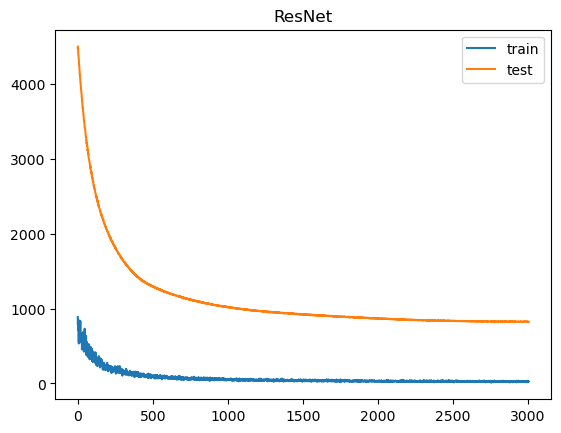

In [ ]:
plt.plot(res_trainloss[200:])
plt.plot(res_testloss[200:])
plt.legend(['train','test'])
plt.title('ResNet')
plt.show()

In [ ]:
#predict
x0=torch.from_numpy(test_x[:300].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:300].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[2036.0021 1979.0992 1982.1678 1992.9504 2033.2422 1990.5587 1991.5238
 1993.0455 1956.7035 2024.8884 1993.752  1971.9182 1984.7587 2086.38
 1968.6139 1988.6139 1986.6417 1998.078  1986.9368 2000.8453 2033.6958
 2011.2865 2006.9769 2001.4838 2003.9198 2010.8566 1982.2084 1988.6368
 1985.7222 1989.421  1977.5104 2000.0085 1997.0186 1998.6189 1985.6687
 1983.4315 1995.4008 1979.2738 1991.8075 1994.5906 2008.23   1972.63
 1986.6146 2040.8832 2007.1626 2092.922  1976.346  2047.3496 2215.3137
 1954.6752 1992.9725 1988.4978 2024.0548 1996.4207 2029.138  2004.4126
 1968.8516 2069.4358 1979.4874 2065.613  2066.519  2061.6912 2070.9036
 2069.4202 1995.1963 2047.2445 2069.4202 2065.765  2072.5208 1975.1646
 1975.4065 1961.1183 1969.0084 1966.1976 1963.385  1956.0413 2101.5544
 2043.2462 2033.6702 2086.1375 1997.1833 1979.5021 1989.474  1959.811
 1986.4248 2000.9965 1964.7544 1995.0864 2003.7578 1989.6285 2013.7294
 2014.4161 1968.5372 2005.7827 1982.3655 1992.0304 2042.7592 1984.8749
 1987.1105 

In [ ]:
#bootstrap  
boottime=80
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResNet()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-7,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
    res_testloss=[]
    t0=time.time()
    for epoch in range(4000):  
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()

        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred,y)
        
        if epoch>100 and float(test_loss)>max(res_testloss[-100:-1]):
            break
        res_testloss.append(float(test_loss))
            
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

100%|██████████| 80/80 [1:16:25<00:00, 57.32s/it]


In [ ]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,77]-bootbase)
upper=bootbase-(sorted_bootlist[:,2]-bootbase)
print("confidence interval length",sorted_bootlist[:,77]-sorted_bootlist[:,2])
resnet_length=(sorted_bootlist[:,77]-sorted_bootlist[:,2]).mean()
print("average confidence interval length",resnet_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
resnet_coverage=cover/300
print("95 coverage",resnet_coverage)

confidence interval length [ 91.24475   82.83154   62.97766  108.848145 163.98572   48.860596
  68.57422   91.62158  146.61694  112.02893   55.386963 107.578
  75.56201  380.45837   81.66504   48.884644  94.85303   41.63501
  38.731934  43.496094 188.48608   75.74841  118.720215  67.242676
  60.298462  74.36316   36.021484  25.378662  42.623413  58.584473
  67.74158   62.881104  27.970947  33.586304  34.0094    46.95337
  43.57373   51.59497   58.186157  37.975586 116.232666 111.09387
 134.71399  428.6919   284.81836  340.1172   162.17908  179.57434
 287.3108   383.43884  216.92896  148.6305   101.88306   81.632324
  82.28577  155.66199   69.056274 137.0426   124.19299  220.83386
 220.65063  223.29517  222.2843   221.5863    82.84924   85.65674
 221.5863   118.88269  219.82373   98.74072  142.6106   132.35693
 110.49182   59.833984  88.326904 100.46936  346.6443   292.86682
 285.05896  594.76196  261.93677  181.11841  143.61084   70.95911
  70.32837  158.66638  260.6626    60.321777  5

## Random Feature

definition of random feature

In [5]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=np.random.randn(1)*gamma
        return w
    elif pdf=='L':
        w=np.random.laplace(1)*gamma
        return w
    elif pdf=='C':
        w=np.random.standard_cauchy(1)*gamma
        return w
    

def sample(pdf, gamma, d):
    return [sample_1d(pdf, gamma) for _ in range(d)]


class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : np.array
        shape (D,d)
    b : np.array
        shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = np.random.uniform(0, 2 * np.pi, self.D)
        self.W = np.reshape(
            np.array([
                sample(self.kernel, self.gamma, self.d)
                for _ in range(self.D)], dtype=np.float32),
            (self.D, self.d))

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : np.array (shape=(n,d))
            Array to transform; must be single dimension vector
        Returns
        -------
        x : np.array (shape=(n,D))
            Feature space transformation of x
        """
        x=pd.DataFrame(x)
        result=np.array([
            np.sqrt(2 / self.D) * np.cos(np.dot(self.W, x.iloc[i]) + self.b) for i in range(len(x))]
            )            
        return result

Linear regression vs single layer random feature model

In [ ]:
model =LinearRegression()
model.fit(train_x, train_y)
y_pretest=model.predict(test_x)
y_pretrain=model.predict(train_x)
print("Linear Ridge train mse:",mean_squared_error(train_y,y_pretrain))
print("test mse:",mean_squared_error(test_y,y_pretest))

score=[]
trainmse=[]
testmse=[]
gaset=np.linspace(0.1,0.5,100)
for ga in gaset:
    rff=RandomFourierFeature(90,30,kernel='G',gamma=ga)
    total_x=pd.concat([train_x,test_x])
    feature=rff.transform(total_x)
    train_xtransformed=feature[:len(train_x)]
    test_xtransformed=feature[len(train_x):]
    model.fit(train_xtransformed, train_y)
    y_pretest=model.predict(test_xtransformed)
    y_pretrain=model.predict(train_xtransformed)
    score.append(cross_val_score(model,train_xtransformed,train_y,cv=5).mean())   ##cross-validation
    trainmse.append(mean_squared_error(y_pretrain,train_y))
    testmse.append(mean_squared_error(y_pretest,test_y))
ind=score.index(max(score))
print("cv-score,index,gamma,trainmse,testmse",max(score),ind,gaset[ind],trainmse[ind],testmse[ind])

Linear Ridge train mse: 74.86242454318058
test mse: 154.0442425294812
cv-score,index,gamma,trainmse,testmse -0.838938290207604 4 0.11616161616161616 104.05082633330724 162.40226684422484


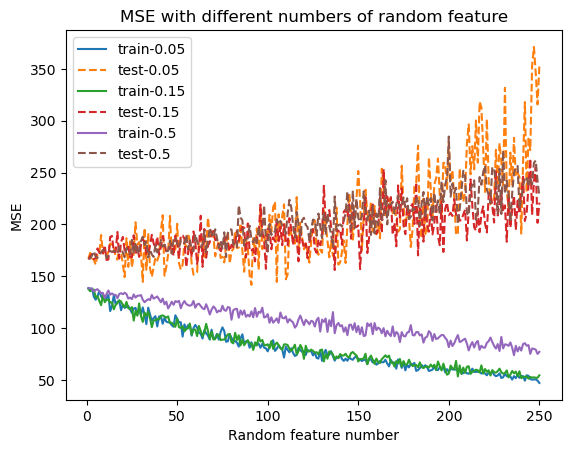

In [ ]:
model =LinearRegression() #without bagging
Layer=1
m0set=np.linspace(1,250,250)
m0set=m0set.astype(int)
gaset=[0.05,0.15,0.5]

for ga in gaset:
    trainmse=[]
    testmse=[]
    t=[]
    for m0 in m0set:  
        rff=RandomFourierFeature(90,m0,kernel='G',gamma=ga)
        total_x=pd.concat([train_x,test_x])
        feature=rff.transform(total_x)
        train_xtransformed=feature[:700]
        test_xtransformed=feature[700:]
            
        model.fit(train_xtransformed, train_y)
        y_pretest=model.predict(test_xtransformed)
        y_pretrain=model.predict(train_xtransformed)
        
        trainmse.append(mean_squared_error(train_y,y_pretrain))
        testmse.append(mean_squared_error(test_y,y_pretest))

    plt.plot(m0set,trainmse)
    plt.plot(m0set,testmse,linestyle='dashed')
    

plt.xlabel("Random feature number")
plt.ylabel("MSE")
plt.title("MSE with different numbers of random feature")
plt.legend(["train-0.05","test-0.05","train-0.15","test-0.15","train-0.5","test-0.5"])
plt.show()

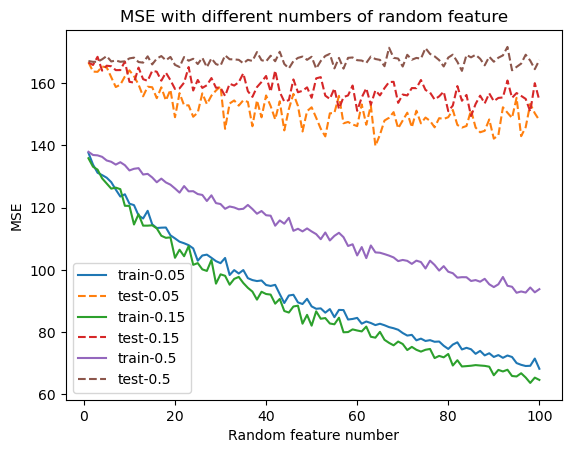

In [ ]:
model =LinearRegression() #bagging
Layer=1
m0set=np.linspace(1,100,100)
m0set=m0set.astype(int)
gaset=[0.05,0.15,0.5]
n0=16

for ga in gaset:
    trainmse=[]
    testmse=[]
    t=[]
    for m0 in m0set:  
        for i in range(n0):
            rff=RandomFourierFeature(90,m0,kernel='G',gamma=ga)
            total_x=pd.concat([train_x,test_x])
            feature=rff.transform(total_x)
            train_xtransformed=feature[:700]
            test_xtransformed=feature[700:]
            
            model.fit(train_xtransformed, train_y)
            if i==0:
                y_pretest=model.predict(test_xtransformed)
                y_pretrain=model.predict(train_xtransformed)
            else:
                y_pretest=y_pretest+model.predict(test_xtransformed)
                y_pretrain=y_pretrain+model.predict(train_xtransformed) 
        
        y_pretest=y_pretest/n0
        y_pretrain=y_pretrain/n0
        
        trainmse.append(mean_squared_error(train_y,y_pretrain))
        testmse.append(mean_squared_error(test_y,y_pretest))

    plt.plot(m0set,trainmse)
    plt.plot(m0set,testmse,linestyle='dashed')
    

plt.xlabel("Random feature number")
plt.ylabel("MSE")
plt.title("MSE with different numbers of random feature")
plt.legend(["train-0.05","test-0.05","train-0.15","test-0.15","train-0.5","test-0.5"])
plt.show()

In [ ]:
model =Ridge(alpha=1)
model.fit(train_x, train_y)
y_pretest=model.predict(test_x)
y_pretrain=model.predict(train_x)
print("Linear Ridge train mse:",mean_squared_error(train_y,y_pretrain))
print("test mse:",mean_squared_error(test_y,y_pretest))

score=[]
trainmse=[]
testmse=[]
gaset=np.linspace(0,0.3,100)
for ga in gaset:
    rff=RandomFourierFeature(90,2000,kernel='G',gamma=ga)
    total_x=pd.concat([train_x,test_x])
    feature=rff.transform(total_x)
    train_xtransformed=feature[:len(train_x)]
    test_xtransformed=feature[len(train_x):]
    model.fit(train_xtransformed, train_y)
    y_pretest=model.predict(test_xtransformed)
    y_pretrain=model.predict(train_xtransformed)
    score.append(cross_val_score(model,train_xtransformed,train_y,cv=5).mean())   ##cross-validation
    trainmse.append(mean_squared_error(y_pretrain,train_y))
    testmse.append(mean_squared_error(y_pretest,test_y))
ind=score.index(max(score))
print("cv-score,index,gamma,trainmse,testmse",max(score),ind,gaset[ind],trainmse[ind],testmse[ind])

Linear Ridge train mse: 74.86409656538211
test mse: 153.7107056787628
cv-score,index,gamma,trainmse,testmse -0.4808480141674825 46 0.1393939393939394 46.73350973569064 152.42049196114354


one single gaussian kernel machine

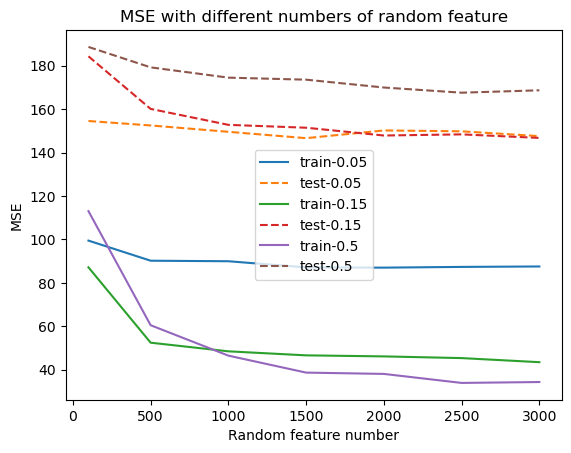

In [ ]:
model=Ridge(alpha=1)
Layer=1
m0set=[100,500,1000,1500,2000,2500,3000]
gaset=[0.05,0.15,0.5]

for ga in gaset:
    trainmse=[]
    testmse=[]
    t=[]
    for m0 in m0set:  
        rff=RandomFourierFeature(90,m0,kernel='G',gamma=ga)
        total_x=pd.concat([train_x,test_x])
        feature=rff.transform(total_x)
        train_xtransformed=feature[:700]
        test_xtransformed=feature[700:]
            
        model.fit(train_xtransformed, train_y)
        y_pretest=model.predict(test_xtransformed)
        y_pretrain=model.predict(train_xtransformed)
        
        trainmse.append(mean_squared_error(train_y,y_pretrain))
        testmse.append(mean_squared_error(test_y,y_pretest))

    plt.plot(m0set,trainmse)
    plt.plot(m0set,testmse,linestyle='dashed')
    

plt.xlabel("Random feature number")
plt.ylabel("MSE")
plt.title("MSE with different numbers of random feature")
plt.legend(["train-0.05","test-0.05","train-0.15","test-0.15","train-0.5","test-0.5"])
plt.show()

# 3. new

In [39]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=torch.randn(1)*gamma
        return w
    elif pdf=='L':
        w=torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    elif pdf=='C':
        w=torch.distributions.cauchy.Cauchy(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    
def sample(pdf, gamma, d):
    return torch.tensor([sample_1d(pdf, gamma) for _ in range(d)])

class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : shape (D,d)
    b : shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = torch.rand(self.D)*2*torch.pi
        self.W = sample(self.kernel, self.gamma, self.d*self.D).reshape(self.D,self.d)

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : (shape=(n,d))
            to transform; must be single dimension vector
        Returns
        -------
        x : (shape=(n,D))
            Feature space transformation of x
        """
        #print(self.W.shape,self.b.reshape(-1,1).shape,x.shape)
        #print((self.W @ x.T).shape)
       
        result=torch.sqrt(torch.tensor([2.0/self.D])) * torch.cos( self.W @ x.T  + (self.b.reshape(-1,1) @ torch.ones(len(x)).reshape(1,-1))) 
        #print(result.T.shape)
        return result.T

In [42]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff1=RandomFourierFeature(90,32,kernel='C',gamma=0.01)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=0.1)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(32, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=8e-4,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)

        test_loss = criterion(y_test_pred,y)
            
    if epoch>100 and float(test_loss)>max(kernelnn_testloss[-100:-1]):
        break
    
    
    if epoch % 100 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
   
    kernelnn_trainloss.append(float(train_loss))
    kernelnn_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 3616684.5
            Test  set - loss: 3525577.0
            
epoch 100
            Train set - loss: 627.8582763671875
            Test  set - loss: 2356.373046875
            
epoch 200
            Train set - loss: 358.8241882324219
            Test  set - loss: 880.0125122070312
            
epoch 300
            Train set - loss: 167.97731018066406
            Test  set - loss: 419.494384765625
            
epoch 400
            Train set - loss: 128.94003295898438
            Test  set - loss: 242.26397705078125
            
epoch 500
            Train set - loss: 115.2811050415039
            Test  set - loss: 167.49900817871094
            
epoch 600
            Train set - loss: 117.99364471435547
            Test  set - loss: 133.92510986328125
            
epoch 700
            Train set - loss: 117.385108947

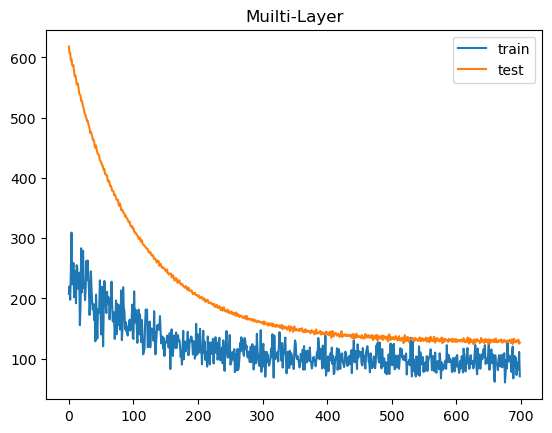

In [42]:
plt.plot(kernelnn_trainloss[200:])
plt.plot(kernelnn_testloss[200:])
plt.legend(['train','test'])
plt.title('Muilti-Layer')
plt.show()

In [44]:
#predict
x0=torch.from_numpy(test_x[:300].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:300].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[1998.5564 1998.8802 2006.1461 1999.6858 1995.4257 1989.2037 1996.3911
 2008.9059 1988.7421 1990.3657 1992.3649 1998.9905 1996.4402 1982.8502
 1999.8406 2008.3035 1983.0754 1999.1195 1995.6504 1982.0403 1996.0724
 2005.2408 1992.6356 2000.556  1994.5834 1997.565  1984.2996 1989.6403
 1998.7717 2011.0629 1982.6854 1987.7572 1994.509  1994.1769 2001.7972
 1987.547  2004.3302 1980.5897 2003.1296 2002.709  1992.1431 2001.4938
 1996.3674 2000.0347 2005.545  1993.5632 2008.7592 1982.8007 1994.3826
 1985.9425 2002.2471 1989.1002 2004.9563 1967.1812 1988.2764 1992.6696
 2002.9319 1984.4976 2003.9099 1986.5045 1986.9325 1999.3246 1993.5918
 1992.2852 1992.2297 1988.0913 1992.2852 1997.6318 1989.7136 1996.3912
 2004.31   1985.5483 1985.962  1982.281  1977.7292 2006.1615 2002.9062
 1988.8688 1982.4545 2014.6257 1987.7733 1989.8457 1972.8179 1992.525
 1991.8885 2000.5254 2004.671  1997.6375 2002.2386 1991.6417 1986.3423
 1992.2839 1996.643  1986.9404 1999.0581 2001.263  1988.5854 1995.5927
 1996.5

In [66]:
#original
#predict
par=optimizer.param_groups[0]['params']

for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
print(Fi.shape)

temp=torch.linalg.inv(Fi.T @ Fi)

length=[]
coverage=0
mark=0
for i in range(len(test_x)):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    #print(pred.detach().numpy()[0][0],test_y[i])
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    #print(2*1.96*np.sqrt(float(fFFf+1))) #approximate with df(infinity)
    
    if fFFf < 0:
        continue
    mark=mark+1
    length.append(2*1.96*np.sqrt(float(fFFf+1))*np.sqrt(kernelnn_trainloss[-1]))
    
    #coverage
    if pred.detach().numpy()[0][0]-1.96*np.sqrt(float(fFFf+1))*np.sqrt(kernelnn_trainloss[-1])<test_y[i] and pred.detach().numpy()[0][0]+1.96*np.sqrt(float(fFFf+1))*np.sqrt(kernelnn_trainloss[-1])>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)


torch.Size([700, 273])
n-p: 427  mark: 300
length 51.85447143174236
95 coverage 0.9266666666666666


In [68]:
#penalty
#predict
wei=1e-4
par=optimizer.param_groups[0]['params']

for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
print(Fi.shape)


temp2=torch.linalg.inv(Fi.T @ Fi+wei *np.eye(Fi.T.shape[0]))
temp2=temp2.float()
temp=temp2@Fi.T @ Fi@temp2
p=Fi @temp2 @Fi.T
print(len(train_x)-np.trace(2*p-p@p))
corr=(len(train_x)-f0.shape[0])/(len(train_x)-np.trace(2*p-p@p))

length=[]
coverage=0
mark=0
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    #print(pred.detach().numpy()[0][0],test_y[i])
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    #print(2*1.96*np.sqrt(float(fFFf+1))) #approximate with df(infinity)
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=1.96*np.sqrt(float(fFFf+1))*np.sqrt(kernelnn_trainloss[-1])*corr
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 700/700 [00:00<00:00, 1195.37it/s]


torch.Size([700, 273])
427.00579833984375


100%|██████████| 300/300 [00:00<00:00, 973.03it/s]

n-p: 427  mark: 300
length 51.798509103695224
95 coverage 0.9266666666666666


In [69]:
##conformal prediction
#predict
par=optimizer.param_groups[0]['params']
for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
temp=torch.linalg.inv(Fi.T @ Fi)

mark=0
score=torch.tensor([])
for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)
    fFFf=f0.T @ temp @ f0
    score=torch.cat([score,np.abs(pred.detach().numpy()[0][0]-train_y[i])/np.sqrt(kernelnn_trainloss[-1])/np.sqrt(fFFf+1)])
    if fFFf < 0:
        continue
    mark=mark+1
score=score.reshape(-1)
sorted_score, sorted_indices=torch.sort(score)
q=(len(train_x)+1)*0.95
print(np.ceil(q))
a=sorted_score[int(np.ceil(q))]



mark=0
length=[]
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark


print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 700/700 [00:00<00:00, 1258.12it/s]


666.0


100%|██████████| 300/300 [00:00<00:00, 1537.67it/s]

length 49.79121061960856
95 coverage 0.9197555555555555


In [70]:
##conformal prediction
#predict
x0=torch.from_numpy(train_x[:].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    score=np.abs(pred.reshape(-1)-train_y[:].to_numpy())
sorted_score, sorted_indices=torch.sort(score)
q=(len(train_x)+1)*0.95
print(np.ceil(q))
a=sorted_score[int(np.ceil(q))]

coverage=0
for i in range(len(test_x)):
    if pred.detach().numpy()[0][0]-a<test_y[i] and pred.detach().numpy()[0][0]+a>test_y[i]:
        coverage=coverage+1
coverage=coverage/len(test_x)

print("length",2*a)
print("95 coverage",coverage)



666.0
length tensor(42.2683, dtype=torch.float64)
95 coverage 0.8533333333333334


In [249]:
#bootstrap  
boottime=80
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = KernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=8e-4,momentum=0.9) #optim.Adam(...)
    kernelnn_testloss=[]
    t0 = time.time()
    for epoch in range(2000): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            loss.append(train_loss)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()

        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred,y)
        
        if epoch>100 and float(test_loss)>max(kernelnn_testloss[-100:-1]):
            break
        kernelnn_testloss.append(float(test_loss))
                
            
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

 14%|█▍        | 11/80 [05:05<33:14, 28.91s/it]

In [ ]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,77]-bootbase)
upper=bootbase-(sorted_bootlist[:,2]-bootbase)
print("confidence interval length",sorted_bootlist[:,77]-sorted_bootlist[:,2])
kernelnet_length=(sorted_bootlist[:,77]-sorted_bootlist[:,2]).mean()
print("average confidence interval length",kernelnet_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
kernelnet_coverage=cover/300
print("95 coverage",kernelnet_coverage)

confidence interval length [48.813843 44.495483 47.101807 52.012817 42.59839  47.36914  47.07251
 46.513916 49.718872 51.67859  43.577637 52.006958 39.97827  59.37976
 52.291138 49.14453  49.558716 40.291504 42.658203 45.173462 46.866333
 42.46106  44.28357  46.630737 47.87146  50.593384 45.09314  48.735718
 47.618042 49.24951  43.50952  52.478027 45.619873 39.45398  47.436768
 59.575317 43.645752 48.744995 44.072998 44.53308  50.95581  49.062134
 44.250977 44.828125 51.98401  49.43811  42.286255 48.28882  44.4021
 47.393677 49.99402  44.107056 49.788574 42.785645 41.028442 42.04187
 43.801514 48.588135 44.399048 44.25232  43.431763 36.768555 46.00476
 49.297974 41.859863 37.477783 49.297974 50.041626 49.89563  50.316406
 47.897583 45.935303 44.420776 39.35559  44.42041  47.845337 49.837524
 46.693237 47.59839  46.834473 43.966553 51.128906 47.923584 47.699585
 44.347168 52.289185 49.751953 40.016846 44.190796 44.637207 39.818604
 49.547485 48.506958 55.031982 45.931152 47.410645 50.53

# 4. new

In [76]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff0=RandomFourierFeature(90,32,kernel='C',gamma=0.01)
rff1=RandomFourierFeature(8,8,kernel='G',gamma=0.1)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=1)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(32,8,rff1)
        self.rblock2 = ResidualBlock(8,8,rff2)
        self.fc3 =nn.Linear(8,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        x = self.rblock2(x)
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
#net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-7,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)

loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(3000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)

        test_loss = criterion(y_test_pred,y)
            
    if epoch>100 and float(test_loss)>max(reskernel_testloss[-100:-1]):
        break
    
    
    if epoch % 100 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    reskernel_trainloss.append(float(train_loss))
    reskernel_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=8, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 3984651.25
            Test  set - loss: 4001398.75
            
epoch 100
            Train set - loss: 2843.0986328125
            Test  set - loss: 917.908935546875
            
epoch 200
            Train set - loss: 554.7686157226562
            Test  set - loss: 344.2388916015625
            
epoch 300
            Train set - loss: 299.433349609375
            Test  set - loss: 196.4102783203125
            
epoch 400
            Train set - loss: 426.9071960449219
            Test  set - loss: 145.5697784423828
            
epoch 500
            Train set - loss: 307.94

In [21]:
#prune
parameters_to_prune = (
    (net.rblock1.fc1, 'weight'),
    (net.rblock1.fc2, 'weight'),
    (net.rblock2.fc1, 'weight'),
    (net.rblock2.fc2, 'weight'),
    (net.fc3, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

prune.remove(net.rblock1.fc1, 'weight')
prune.remove(net.rblock1.fc2, 'weight')
prune.remove(net.rblock2.fc1, 'weight')
prune.remove(net.rblock2.fc2, 'weight')
prune.remove(net.fc3, 'weight')

for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    y_test_pred = net(x)
    y_test_pred = torch.squeeze(y_test_pred)
        
    test_loss = criterion(y_test_pred,y)
print(f'''epoch {epoch}
        Train set - loss: {train_loss}
        Test  set - loss: {test_loss}
        ''')

epoch 1520
        Train set - loss: 191.67117309570312
        Test  set - loss: 195.55484008789062
        


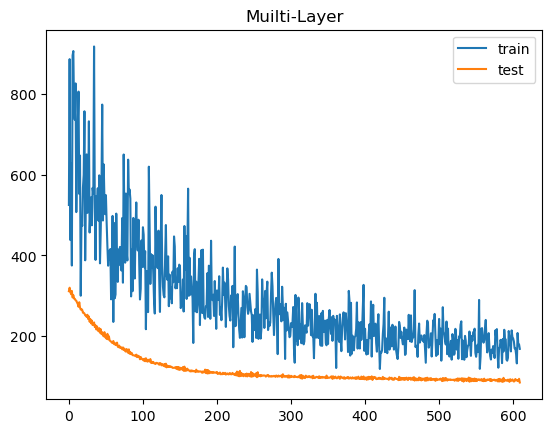

In [12]:
plt.plot(reskernel_trainloss[200:])
plt.plot(reskernel_testloss[200:])
plt.legend(['train','test'])
plt.title('Muilti-Layer')
plt.show()

In [17]:
#predict
x0=torch.from_numpy(test_x[:300].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:300].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[1997.3486 1997.4701 1995.7069 1992.1246 1992.558  1995.1877 1991.9742
 1989.93   1995.2743 1993.276  1994.9934 1996.9142 1998.4955 2007.0918
 2001.2977 1994.149  1994.4537 1994.6755 1993.1151 1993.4315 2002.0961
 1997.3274 2005.1022 2003.5736 1996.0442 1996.2882 1997.0488 1993.8202
 1994.8555 1993.3579 1995.1158 1995.6008 1992.1289 1990.6791 1993.1947
 1996.6259 1998.4869 2000.6038 2001.1753 1995.4233 2000.696  1998.09
 1995.1544 2002.9753 1996.9525 2001.0135 1993.1428 1998.7426 1999.7554
 2003.1698 2001.0935 1994.9609 1996.9122 1993.9816 1992.386  1992.2073
 1994.4592 1995.7748 2000.2208 2005.953  2005.7694 2005.798  2006.4291
 2006.5282 1999.297  2000.1086 2006.5282 1998.1044 2006.4294 1994.5553
 1991.7577 1992.9697 1995.2626 1997.6307 1998.9908 1994.5018 1988.4865
 2003.5236 1992.9149 1999.4159 2000.8292 1997.3999 2000.1974 1997.3575
 1995.733  1996.3483 2002.0327 1996.1517 1993.398  1995.1315 1998.9125
 1997.327  1994.8403 1992.7057 1992.932  1993.4308 1995.5098 1995.4756
 1996.76

In [77]:
#original
#predict
par=optimizer.param_groups[0]['params']

for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
print(Fi.shape)

temp=torch.linalg.pinv(Fi.T @ Fi)

length=[]
coverage=0
mark=0
for i in range(len(test_x)):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    #print(pred.detach().numpy()[0][0],test_y[i])
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    #print(2*1.96*np.sqrt(float(fFFf+1))) #approximate with df(infinity)
    
    if fFFf < 0:
        continue
    mark=mark+1
    length.append(2*1.96*np.sqrt(float(fFFf+1))*np.sqrt(reskernel_testloss[-1]))
    
    #coverage
    if pred.detach().numpy()[0][0]-1.96*np.sqrt(float(fFFf+1))*np.sqrt(reskernel_testloss[-1])<test_y[i] and pred.detach().numpy()[0][0]+1.96*np.sqrt(float(fFFf+1))*np.sqrt(reskernel_testloss[-1])>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)


torch.Size([700, 489])
n-p: 211  mark: 300
length 37.24112414378031
95 coverage 0.8333333333333334


In [78]:
#penalty
#predict
wei=1e-4
par=optimizer.param_groups[0]['params']

for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
print(Fi.shape)


temp2=torch.linalg.inv(Fi.T @ Fi+wei *np.eye(Fi.T.shape[0]))
temp2=temp2.float()
temp=temp2@Fi.T @ Fi@temp2
p=Fi @temp2 @Fi.T
print(len(train_x)-np.trace(2*p-p@p))
corr=(len(train_x)-f0.shape[0])/(len(train_x)-np.trace(2*p-p@p))

length=[]
coverage=0
mark=0
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    #print(pred.detach().numpy()[0][0],test_y[i])
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    #print(2*1.96*np.sqrt(float(fFFf+1))) #approximate with df(infinity)
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=1.96*np.sqrt(float(fFFf+1))*np.sqrt(reskernel_trainloss[-1])*corr
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 700/700 [00:00<00:00, 757.30it/s]


torch.Size([700, 489])
852.6112670898438


100%|██████████| 300/300 [00:00<00:00, 840.55it/s]

n-p: 211  mark: 197
length 38.34746752441462
95 coverage 0.7563451776649747


In [80]:
##conformal prediction
#predict
par=optimizer.param_groups[0]['params']
for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
temp=torch.linalg.inv(Fi.T @ Fi)

mark=0
score=torch.tensor([])
for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)
    fFFf=f0.T @ temp @ f0
    score=torch.cat([score,np.abs(pred.detach().numpy()[0][0]-train_y[i])/np.sqrt(reskernel_trainloss[-1])/np.sqrt(fFFf+1)])
    if fFFf < 0:
        continue
    mark=mark+1
score=score.reshape(-1)
sorted_score, sorted_indices=torch.sort(score)
q=(len(train_x)+1)*0.95
print(np.ceil(q))
a=sorted_score[int(np.ceil(q))]



mark=0
length=[]
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=(np.sqrt(reskernel_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark


print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 700/700 [00:00<00:00, 730.54it/s]


666.0


100%|██████████| 300/300 [00:00<00:00, 727.41it/s]

length 55.05064226233441
95 coverage 0.9259308807134895


In [79]:
##conformal prediction
#predict
x0=torch.from_numpy(train_x[:].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    score=np.abs(pred.reshape(-1)-train_y[:].to_numpy())
sorted_score, sorted_indices=torch.sort(score)
q=(len(train_x)+1)*0.95
print(np.ceil(q))
a=sorted_score[int(np.ceil(q))]

coverage=0
for i in range(len(test_x)):
    if pred.detach().numpy()[0][0]-a<test_y[i] and pred.detach().numpy()[0][0]+a>test_y[i]:
        coverage=coverage+1
coverage=coverage/len(test_x)

print("length",2*a)
print("95 coverage",coverage)


666.0
length tensor(48.7051, dtype=torch.float64)
95 coverage 0.8533333333333334


In [19]:
#bootstrap  
boottime=80
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResKernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-7,momentum=0.9) #optim.Adam(...)
    reskernel_testloss=[]
    t0 = time.time()
    for epoch in range(2000): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()
        

        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred,y)
        
        if epoch>100 and float(test_loss)>max(reskernel_testloss[-100:-1]):
            break
        reskernel_testloss.append(float(test_loss))
    
            
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

100%|██████████| 80/80 [38:43<00:00, 29.05s/it]


In [20]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,77]-bootbase)
upper=bootbase-(sorted_bootlist[:,2]-bootbase)
print("confidence interval length",sorted_bootlist[:,77]-sorted_bootlist[:,2])
reskernelnet_length=(sorted_bootlist[:,77]-sorted_bootlist[:,2]).mean()
print("average confidence interval length",reskernelnet_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
reskernelnet_coverage=cover/300
print("95 coverage",reskernelnet_coverage)

confidence interval length [29.467773  23.62915   19.554443  23.415894  26.885742  19.25708
 15.712402  23.035522  44.379395  31.759155  19.825073  28.528198
 33.384644  32.7771    22.745728  21.912354  19.40686   21.70642
 17.87561   22.324951  25.774414  34.90674   23.078491  20.907593
 18.185303  27.31836   17.677246  29.081055  17.854248  16.37146
 20.31543   17.74292   14.713135  25.057251  17.301636  14.200562
 16.593872  17.655762  11.9053955 19.049072  18.790771  20.665527
 17.552246  31.51001   41.7157    43.53003   39.385864  28.002441
 34.0448    37.352295  22.310791  38.727417  23.60083   38.74768
 29.660522  45.60315   34.861816  27.175293  21.6073    27.605347
 29.417358  24.790527  25.516357  26.461304  24.796875  21.498535
 26.461304  22.591309  30.399414  27.811157  49.447266  22.332275
 21.391235  19.913208  30.549316  22.095215  60.81787   29.83081
 43.039795  28.55896   41.812378  28.318237  30.241577  25.130493
 24.720825  39.44568   55.35608   25.47522   18.802734

comparison

In [ ]:
def plot_choose(fig,start,data):
    fig.plot(np.arange(start,len(data)),data[start:])

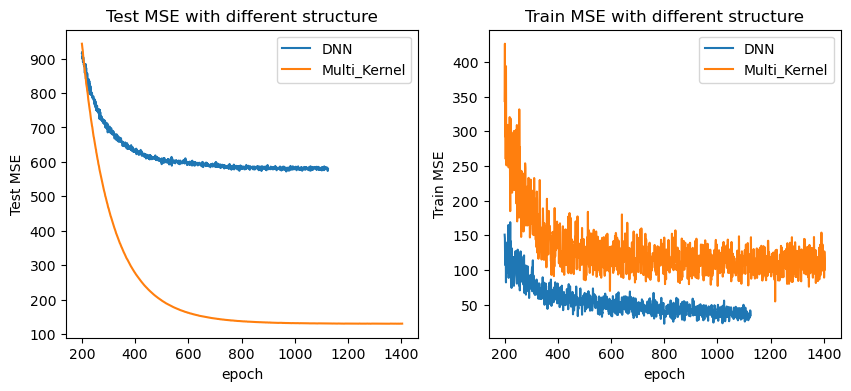

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_choose(ax[0],200,dnn_testloss)
plot_choose(ax[0],200,kernelnn_testloss)
ax[0].legend(["DNN","Multi_Kernel"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Test MSE")
ax[0].set_title("Test MSE with different structure")

plot_choose(ax[1],200,dnn_trainloss)
plot_choose(ax[1],200,kernelnn_trainloss)
ax[1].legend(["DNN","Multi_Kernel"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Train MSE")
ax[1].set_title("Train MSE with different structure")
plt.show()

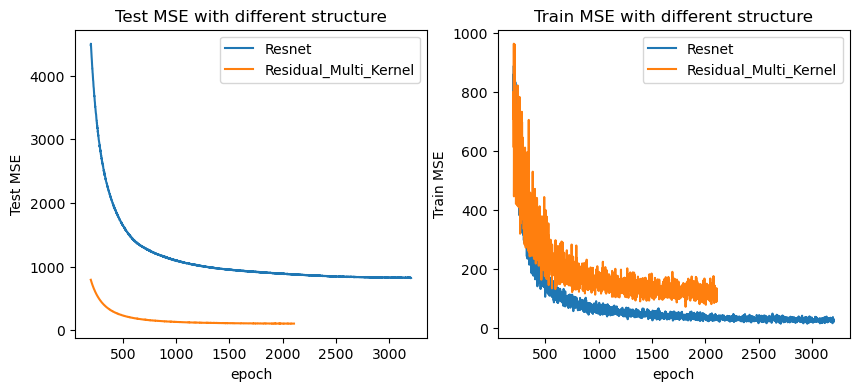

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_choose(ax[0],200,res_testloss)
plot_choose(ax[0],200,reskernel_testloss)
ax[0].legend(["Resnet","Residual_Multi_Kernel"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Test MSE")
ax[0].set_title("Test MSE with different structure")

plot_choose(ax[1],200,res_trainloss)
plot_choose(ax[1],200,reskernel_trainloss)
ax[1].legend(["Resnet","Residual_Multi_Kernel"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Train MSE")
ax[1].set_title("Train MSE with different structure")
plt.show()

In [22]:
dnn_length=107.71   
resnet_length=108.98 
kernelnet_length=46.51
reskernelnet_length=25.80 
dnn_coverage=0.913333
resnet_coverage=0.91
kernelnet_coverage=0.81
reskernelnet_coverage=0.59

[107.71, 108.98, 46.51, 25.8] [9.133329999999999, 9.1, 8.100000000000001, 5.8999999999999995]


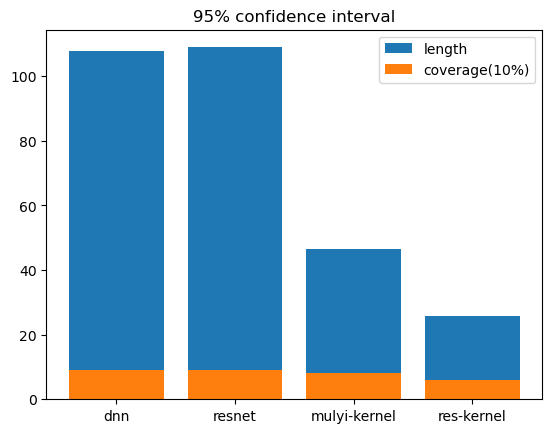

In [23]:
length=[dnn_length,resnet_length,kernelnet_length,reskernelnet_length]
coverage=[10*dnn_coverage,10*resnet_coverage,10*kernelnet_coverage,10*reskernelnet_coverage]
name=['dnn','resnet','mulyi-kernel','res-kernel']
print(length,coverage)
plt.bar(name,length)
plt.bar(name,coverage)
plt.legend(['length','coverage(10%)'])
plt.title("95% confidence interval")
plt.show()

## 3+. multi-layer learning (data splitting) 

In [207]:
#multi
split=2
layer=2
length=int(len(train_x)/layer)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff1=RandomFourierFeature(90,32,kernel='C',gamma=0.01)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=0.1)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(32, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)
        
train_loaderset=[] # there are "split" elements
netset=[]
optimizerset=[]
train_loss=[]
test_loss=[]

np.random.seed(0)
row_rand_array = np.arange(train_x.shape[0])
np.random.shuffle(row_rand_array)

train_loaderset1=[]
for l in range(layer): #split into different dataset
    curx=train_x.values[row_rand_array[l*length:(l+1)*length]]
    cury=train_y.values[row_rand_array[l*length:(l+1)*length]]
    nnx = torch.from_numpy(curx).float()
    nny = torch.squeeze(torch.from_numpy(cury).float()) 
    train_loader = DataLoader(mydataset(nnx, nny),batch_size=100, shuffle=True)
    train_loaderset1.append(train_loader)
    
for i in range(split):
    train_loaderset1=train_loaderset1[1:]+train_loaderset1[0:1]
    train_loaderset.append(train_loaderset1)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = KernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    netset.append(net)      
   
    optimizer1=[]
    optimizer1.append(optim.SGD([{'params': net.fc1.parameters()}],lr=8e-4,momentum=0.9,weight_decay=1e-4) )
    optimizer1.append(optim.SGD([{'params': net.fc2.parameters()}],lr=8e-4,momentum=0.9,weight_decay=1e-4) )
    optimizerset.append(optimizer1)
    
    train_loss.append(0)
    test_loss.append(0)
    
criterion=nn.MSELoss()    
loss=[]
splkernel_trainloss=[]
splkernel_testloss=[]
t0 = time.time()
for epoch in range(3000): 
    for i in range(split):
        for l in range(layer):
            for x, y in train_loaderset[i][l]: #for batch, (x, y) in enumerate(train_loader): 
                # Data Splitting
                # every step, update a layer with smaller dataset 
                x, y = x.to(device), y.to(device)
                # Compute prediction error
                y_pred = netset[i](x)
                y_pred = torch.squeeze(y_pred)
                train_loss[i] = criterion(y_pred, y)
                
                # Backpropagation
                optimizerset[i][l].zero_grad() 
                train_loss[i].backward()
                optimizerset[i][l].step()
            
    
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        for i in range(split):
            y_test_pred = netset[i](x)
            y_test_pred = torch.squeeze(y_test_pred)
            
            test_loss[i] = criterion(y_test_pred,y)
    
    if epoch>100 and float(sum(test_loss)/len(test_loss))>max(splkernel_testloss[-100:-1]):
        break
    
    if epoch % 100 == 0: 
        print(f'''epoch {epoch}
            Train set - loss: {sum(train_loss)/len(train_loss)}
            Test  set - loss: {sum(test_loss)/len(test_loss)}
            ''')
    splkernel_trainloss.append(float(sum(train_loss)/len(train_loss)))
    splkernel_testloss.append(float(sum(test_loss)/len(test_loss)))
            
        
dnn_fit = time.time() - t0
print("KernelNet(data splitting) complexity and model fitted in %.3f s" % dnn_fit)

epoch 0
            Train set - loss: 3857446.5
            Test  set - loss: 3790828.75
            
epoch 100
            Train set - loss: 1941.707275390625
            Test  set - loss: 2110.286376953125
            
epoch 200
            Train set - loss: 436.1207275390625
            Test  set - loss: 433.13348388671875
            
epoch 300
            Train set - loss: 174.76626586914062
            Test  set - loss: 137.98922729492188
            
epoch 400
            Train set - loss: 151.57498168945312
            Test  set - loss: 78.03938293457031
            
epoch 500
            Train set - loss: 120.49896240234375
            Test  set - loss: 64.96516418457031
            
epoch 600
            Train set - loss: 139.9557647705078
            Test  set - loss: 62.354949951171875
            
epoch 700
            Train set - loss: 138.7322998046875
            Test  set - loss: 62.10910415649414
            
KernelNet(data splitting) complexity and model fitted in 20

In [208]:
print(y_test_pred,y)

tensor([1997.0497, 1995.9556, 1995.9102, 1994.3363, 1997.0413, 1996.9580,
        1999.2828, 1995.8419, 1996.3875, 1997.0204, 1996.6395, 1996.9438,
        1995.1858, 1994.5197, 1995.7203, 1995.7490, 1997.6000, 1994.8329,
        1995.8337, 1996.2083, 1995.3529, 1997.7809, 1997.9272, 1996.7438,
        1995.1527, 1996.1514, 1995.3840, 1996.3594, 1997.0782, 1998.1587,
        1997.1792, 1997.6056, 1996.8549, 1995.5217, 1996.8514, 1996.7216,
        1997.0341, 1999.1886, 1997.6478, 1999.2615, 1996.9768, 1997.6940,
        1996.9144, 1996.9991, 1996.7635, 1996.0161, 1996.8795, 1998.9281,
        1997.0198, 1997.4058, 1995.7892, 1996.1682, 1997.0094, 1996.8712,
        1997.1831, 1997.9554, 1996.5908, 1997.9175, 1996.7711, 1998.2589,
        1996.7802, 1995.0060, 1998.5557, 1997.2657, 1996.0082, 1995.1770,
        1996.3976, 1996.2841, 1997.1296, 1995.6267, 1996.6741, 1994.8687,
        1996.2743, 1998.5662, 1998.1851, 1996.3458, 1997.2385, 1997.4502,
        1997.3549, 1995.3953, 1997.828

## 4+. residual learning (data splitting) 

In [192]:
#res
split=3
layer=3
length=int(len(train_x)/layer)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff0=RandomFourierFeature(90,32,kernel='C',gamma=0.01)
rff1=RandomFourierFeature(8,8,kernel='G',gamma=0.1)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=1)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(32,8,rff1)
        self.rblock2 = ResidualBlock(8,8,rff2)
        self.fc3 =nn.Linear(8,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        x = self.rblock2(x)
        return self.fc3(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)
        
train_loaderset=[] # there are "split" elements
netset=[]
optimizerset=[]
train_loss=[]
test_loss=[]

np.random.seed(0)
row_rand_array = np.arange(train_x.shape[0])
np.random.shuffle(row_rand_array)

train_loaderset1=[]
for l in range(layer): #split into different dataset
    curx=train_x.values[row_rand_array[l*length:(l+1)*length]]
    cury=train_y.values[row_rand_array[l*length:(l+1)*length]]
    nnx = torch.from_numpy(curx).float()
    nny = torch.squeeze(torch.from_numpy(cury).float()) 
    train_loader = DataLoader(mydataset(nnx, nny),batch_size=100, shuffle=True)
    train_loaderset1.append(train_loader)
    
for i in range(split):
    train_loaderset1=train_loaderset1[1:]+train_loaderset1[0:1]
    train_loaderset.append(train_loaderset1)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResKernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    netset.append(net)      
   
    optimizer1=[]
    optimizer1.append(optim.SGD([{'params': net.rblock1.parameters()}],lr=1e-6,momentum=0.9) )
    optimizer1.append(optim.SGD([{'params': net.rblock2.parameters()}],lr=1e-6,momentum=0.9) )
    optimizer1.append(optim.SGD([{'params': net.fc3.parameters()}],lr=1e-6,momentum=0.9) )
    optimizerset.append(optimizer1)
    
    train_loss.append(0)
    test_loss.append(0)
    
criterion=nn.MSELoss()    
loss=[]
splreskernel_trainloss=[]
splreskernel_testloss=[]
t0 = time.time()
for epoch in range(3000): 
    for i in range(split):
        for l in range(layer):
            for x, y in train_loaderset[i][l]: #for batch, (x, y) in enumerate(train_loader): 
                # Data Splitting
                # every step, update a layer with smaller dataset 
                x, y = x.to(device), y.to(device)
                # Compute prediction error
                y_pred = netset[i](x)
                y_pred = torch.squeeze(y_pred)
                train_loss[i] = criterion(y_pred, y)
                
                # Backpropagation
                optimizerset[i][l].zero_grad() 
                train_loss[i].backward()
                optimizerset[i][l].step()
            
    
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        for i in range(split):
            y_test_pred = netset[i](x)
            y_test_pred = torch.squeeze(y_test_pred)
            
            test_loss[i] = criterion(y_test_pred,y)
    
    if epoch>100 and float(sum(test_loss)/len(test_loss))>max(splreskernel_testloss[-100:-1]):
        break
    
    if epoch % 100 == 0: 
        print(f'''epoch {epoch}
            Train set - loss: {sum(train_loss)/len(train_loss)}
            Test  set - loss: {sum(test_loss)/len(test_loss)}
            ''')
    splreskernel_trainloss.append(float(sum(train_loss)/len(train_loss)))
    splreskernel_testloss.append(float(sum(test_loss)/len(test_loss)))
            
        
dnn_fit = time.time() - t0
print("ResKernelNet(data splitting) complexity and model fitted in %.3f s" % dnn_fit)

epoch 0
            Train set - loss: 3877211.75
            Test  set - loss: 3895507.0
            
epoch 100
            Train set - loss: 1206.267578125
            Test  set - loss: 698.421630859375
            
epoch 200
            Train set - loss: 627.768798828125
            Test  set - loss: 265.92578125
            
epoch 300
            Train set - loss: 283.1507873535156
            Test  set - loss: 168.27606201171875
            
epoch 400
            Train set - loss: 259.06365966796875
            Test  set - loss: 137.9951629638672
            
epoch 500
            Train set - loss: 173.8419952392578
            Test  set - loss: 122.834228515625
            
epoch 600
            Train set - loss: 225.733642578125
            Test  set - loss: 110.188232421875
            
epoch 700
            Train set - loss: 173.1765594482422
            Test  set - loss: 105.9933090209961
            
epoch 800
            Train set - loss: 224.7108612060547
            Test  

In [194]:
print(y_test_pred,y)

tensor([1982.3904, 2011.7432, 1992.4971, 2014.6364, 1998.4387, 1981.8972,
        2003.9163, 1990.8472, 2004.7805, 1980.2324, 1986.8179, 1985.9714,
        1998.0648, 2008.9573, 1998.2487, 1981.9100, 1990.9602, 1998.7893,
        1990.5107, 1997.8452, 1982.5905, 1991.8555, 1990.5690, 1986.7310,
        2013.8074, 2007.2883, 1985.2693, 1992.4561, 1994.9218, 2003.5712,
        2006.0126, 2005.9216, 1991.0963, 1981.5977, 1995.3340, 1990.2938,
        1982.0891, 1982.5773, 1979.1515, 1997.8407, 1999.8984, 1993.2350,
        1995.7684, 2006.5328, 1977.2036, 2003.8403, 1993.8134, 1995.1926,
        1977.8972, 1995.2740, 1984.1761, 1994.5317, 2002.0190, 2006.9479,
        1994.7301, 1998.7087, 1989.2343, 1983.5293, 1987.2545, 1998.7946,
        2007.6499, 2029.1614, 2002.8391, 1993.0250, 2009.0603, 1999.9077,
        2008.0830, 2010.5801, 2010.5299, 1995.6208, 1993.6973, 2000.2109,
        1980.3494, 1997.4346, 1984.8950, 1985.3674, 2005.8335, 2002.0015,
        1990.6500, 1978.9108, 1988.994